In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [66]:
#@title Input Parameters

#Parth Trial Runs
# filepath = "15-53-49.csv" #20 deg - no stop idx for some reason
# filepath = "16-00-31.csv" #30
#filepath = "16-05-42.csv" #60
# filepath = "16-08-04.csv" #control
#filepath = "p115.csv" #P1control
filepath = "Nik60.csv"   

correction_period = 60

In [67]:
#@title Initialize Data
stop_idx = 0
df = pd.read_csv(filepath, header=None, usecols=[0, 1])
df.columns = ["distance", "flashing"]

# Get start/stop indices
start_indices = df["flashing"][df["flashing"] == 'Start'].index
stop_indices = df["flashing"][df["flashing"] == 'Stop'].index


start_idx = start_indices[0]

# Get flashing indices
flashing_on_indices = df["flashing"][df["flashing"] == 'Flashing On'].index
flashing_off_indices = df["flashing"][df["flashing"] == 'Flashing Off'].index

#Remove any flashes before start label
flashing_on_indices = flashing_on_indices[flashing_on_indices >= start_idx]
flashing_off_indices = flashing_off_indices[flashing_off_indices >= start_idx]

In [68]:
#@title Clean Data

#If it begins with Flashing Off, then remove it

# Check if first flashing event is "Flashing Off"
print(flashing_off_indices)
if len(flashing_off_indices) > 0 and len(flashing_on_indices) > 0:
    first_off = flashing_off_indices[0]
    first_on = flashing_on_indices[0]

    if first_off < first_on:
        print(f"\nFirst flashing event is 'Flashing Off' at index {first_off}. Ignoring this event.")
        flashing_off_indices = flashing_off_indices[1:]
        print("modified flashing off:")
        print(flashing_off_indices)
    else:
        print(f"\nFirst flashing event is 'Flashing On' at index {first_on}. Keeping all events.")


# DEBUG INFO FOR CALCULATING CORRECTION PERIOD
# print("\nOriginal Indices:")
# print(f"Start indices: {start_indices.tolist()}")
# print(f"Stop indices: {stop_indices.tolist()}")
# print("\nFlashing change points:")
# for on_idx, off_idx in zip(flashing_on_indices, flashing_off_indices):
#   print(f"Original: ON at {on_idx}, OFF at {off_idx}")
#   print(f"After correction: ON at {on_idx}, OFF at {off_idx + correction_period}")
#   print(f"Indices being changed from OFF to ON: {list(range(off_idx, off_idx + correction_period))}")


#If no stop index, approximate it
if len(stop_indices) == 0:
  stop_indices = pd.Index([start_indices[0] + 6061]) #6061 is approximately how many indexes there are between Stop and Start normally

Index([83, 280, 347, 595, 857, 1358, 1604], dtype='int64')

First flashing event is 'Flashing On' at index 44. Keeping all events.


In [69]:
#@title Calculate Correction Period

# Create a new column for the corrected flashing status
df['corrected_flashing'] = df["flashing"].copy()

# Initialize all entries as "Flashing Off"
df["corrected_flashing"] = "Flashing Off"


# Set periods between Flashing On and corrected Flashing Off as "Flashing On"
for on_idx, off_idx in zip(flashing_on_indices, flashing_off_indices):
    corrected_off_idx = off_idx + correction_period
    df.loc[on_idx:corrected_off_idx, "corrected_flashing"] = "Flashing On"

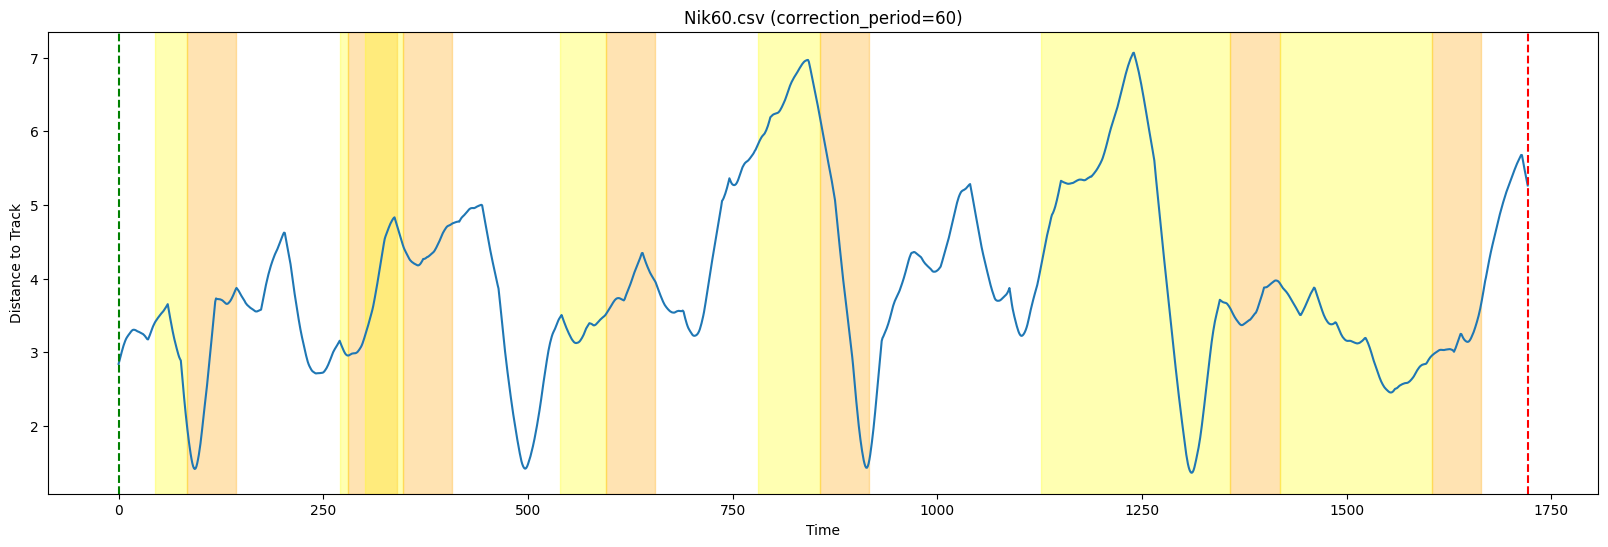

In [70]:
#@title Plot
plt.figure(figsize=(20,6))
plt.plot(df["distance"], label='Distance')
plt.title(f"{filepath} (correction_period={correction_period})")

plt.xlabel('Time')
plt.ylabel('Distance to Track')

# Plot start/stop
for start_idx in start_indices:
    plt.axvline(x=start_idx, color='green', linestyle='--', label='Start')
for stop_idx in stop_indices:
    plt.axvline(x=stop_idx, color='red', linestyle='--', label='Stop')


# Highlight original and corrected flashing periods differently
for on_idx, off_idx in zip(flashing_on_indices, flashing_off_indices):
    # Original flashing period
    plt.axvspan(on_idx, off_idx, color='yellow', alpha=0.3, label='Original Flashing On')
    # Correction period
    plt.axvspan(off_idx, off_idx + correction_period, color='orange', alpha=0.3, label='Correction Period')


#plt.legend()
plt.show()

In [71]:
#@title Get statistics for flashing/non-flashing segments

# Calculate statistics for each trial
i = 0
for start, stop in zip(start_indices, stop_indices):
    print(f"\nAnalyzing segment from index {start} to {stop}")
    segment = df.loc[start:stop]


    # Print counts for verification
    print("\nData point counts:")
    print(f"Original Flashing On: {len(segment[segment['flashing'] == 'Flashing On'])}")
    print(f"Corrected Flashing On: {len(segment[segment['corrected_flashing'] == 'Flashing On'])}")
    print(f"Difference: {len(segment[segment['corrected_flashing'] == 'Flashing On']) - len(segment[segment['flashing'] == 'Flashing On'])}")


    no_flashing_segment = segment[segment["corrected_flashing"] == 'Flashing Off']
    yes_flashing_segment = segment[segment["corrected_flashing"] == 'Flashing On']

    no_flashing_mean = no_flashing_segment['distance'].mean()
    no_flashing_std = no_flashing_segment['distance'].std()
    yes_flashing_mean = yes_flashing_segment['distance'].mean()
    yes_flashing_std = yes_flashing_segment['distance'].std()

    total_std = segment['distance'].std()
    total_mean = segment['distance'].mean()

    print(f"Trial {i}\nNo Flashing:\n\tMean: {no_flashing_mean}\n\tSTD: {no_flashing_std}\nFlashing:\n\tMean: {yes_flashing_mean}\n\tSTD: {yes_flashing_std}\nTotal:\n\tMean: {total_mean}\n\tSTD: {total_std}\n")
    i += 1


Analyzing segment from index 0 to 1721

Data point counts:
Original Flashing On: 8
Corrected Flashing On: 1030
Difference: 1022
Trial 0
No Flashing:
	Mean: 3.88442387283237
	STD: 0.961478263963248
Flashing:
	Mean: 3.945222495145631
	STD: 1.3235818999814175
Total:
	Mean: 3.9207900638792106
	STD: 1.1914355480120167
